# POC-Turtle category learner, part 1
This is part 1 of proof-of-concept (POC) experiments in unsupervised language learning (ULL).  
This notebook is available as a [static html page](http://88.99.210.144/data/clustering_2018/html/POC-Turtle-1-2018-02-09.html), the code is shared via [GitHub](https://github.com/opencog/language-learning), detailed output files and comments are in the [project shared directory](http://88.99.210.144/data/clustering_2018/POC-Turtle-1-2018-02-09/).  
  
We use a simplified "Turtle language" corpus:

In [1]:
input_file = '../data/poc-turtle-sentences.txt'
with open(input_file, 'r') as f: lines = f.read().splitlines()
for line in lines: print(line)

tuna isa fish.
herring isa fish.
tuna has fin.
herring has fin.
parrot isa bird.
eagle isa bird.
parrot has wing.
eagle has wing.
fin isa extremity.
wing isa extremity.
fin has scale.
wing has feather.



In [2]:
import os, sys, time, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
from src.utl.utl import UTC
from src.space.turtle import dumb_parser, parses2vec
from src.utl.turtle import save_txt_and_readme, html_table, readmes
from src.clustering.kmeans import cluster_kmeans, cluster_top_words
print(UTC(), ':: module_path:', module_path)

2018-02-09 14:00:11 UTC :: module_path: /home/obaskov/language-learning


## 1.1 Settings

In [3]:
prj_dir = '../Turtle-2018-02-09/'  # project directory
prefix = ''     # all project files will start with this prefix
verbose = 'min' # printed comments: 'none', 'min', 'max'
log = {'project': 'POC-Turtle-1 v.1'}

if not os.path.isfile(input_file):
    print('No data file', module_path + input_file[2:])
else: print('Data file found:', module_path + input_file[2:])
if not os.path.exists(prj_dir):
    os.makedirs(prj_dir)
    print('Project directory created:', module_path + prj_dir[2:])
else: print('Project directory', module_path + prj_dir[2:], 'exists')
if verbose == 'max': print(UTC(), log)
log.update({'input_file': module_path + input_file[2:]})

Data file found: /home/obaskov/language-learning/data/poc-turtle-sentences.txt
Project directory /home/obaskov/language-learning/Turtle-2018-02-09/ exists


## 1.2 Parse sentences to links (word pairs) 

In [4]:
parses = dumb_parser(input_file, verbose)
if verbose != 'none': print('parses:', type(parses), len(parses), 'items') 
if verbose == 'max': 
    with pd.option_context('display.max_rows', 8): print(parses, '\n')

parses: <class 'pandas.core.frame.DataFrame'> 48 items


## 1.3 Create word space, vector space
We create a word-connector space by converting each link (word pair) into a couple of links (connectors) between the word and its left and right neighbours. An ('a','b') link (word pair) is converted to ('a','b+') and ('b','a-'). The wordspace is a matrix of **N** by 2\***N** , where N is the number of words in the corpus. Each cell of the matrix represents the number of occasions of the word pair in the corpus.  
  
The word vector space is created based on the word space data. Each word is represented by a vector of 2\***N** length. Each vector component represents pointwise mutual information (PMI) of the wordpair in the corpus. Word space dimensionality reduction is performed with [SVD algorithm](https://en.wikipedia.org/wiki/Singular-value_decomposition).

More details about the implemeted method -- [Omer Levy et al. Improving Distributional Similarity with Lessons Learned from Word Embeddings, 2015.](https://drive.google.com/open?id=1liINLNegI-B-KTTpPzpOmoZSd5VbygQ_)

In [5]:
# Create word space: ('a','b') » ('a','b+'), ('b','a-') »» vectors
path = module_path + prj_dir[2:]    # path to vectors
tmpath = module_path + '/tmp/'      # path for temporary files
dim = 4     # Vector space dimensions
cds = 1.0   # Context distribution smoothing [default: 1.0]
eig = 0.5   # Weighted exponent of the eigenvalue matrix [default: 0.5]
neg = 1     # Number of negative samples, subtracts its log from PMI [default: 1] 
vdf,res1 = parses2vec(parses,path,tmpath,dim,cds,eig,neg,'none')
log.update(res1)
vdf

,word,1,2,3,4
0,###LEFT-WALL###,-6.460635e-01,-5.764377e-15,-7.632837e-01,-1.575067e-14
1,.,-4.088669e-01,-1.997218e-15,9.125940e-01,-1.368956e-14
2,bird,-5.612674e-16,3.732532e-01,3.630581e-16,-9.277295e-01
3,eagle,1.941694e-17,8.575293e-01,-1.423570e-15,5.144352e-01
4,extremity,-5.612674e-16,3.732532e-01,3.630581e-16,-9.277295e-01
5,feather,-5.401612e-16,6.074431e-01,4.730129e-16,-7.943632e-01
6,fin,-3.608714e-16,9.878350e-01,-1.400656e-15,-1.555057e-01
7,fish,-5.612674e-16,3.732532e-01,3.630581e-16,-9.277295e-01
8,has,-9.364446e-01,-5.819293e-15,-3.508156e-01,-3.752519e-14
9,herring,1.941694e-17,8.575293e-01,-1.423570e-15,5.144352e-01


## 1.4 Characterize dimensions in vector space
For each axis (dimension) in the previous table we can see two groups of words: the one remote from the axis zero (absolute values ~ e-1) and the other close to the axis zero (absolute values ~ e-16). Let's see more details:

### 1.4.1 Top words for axes by the axis absolute value

In [6]:
for x in range(1, dim+1):
    top = vdf.loc[abs(vdf[x])>1e-12].sort_values(by=x, ascending=False)
    top_words = top['word'].tolist()
    values = top[x].tolist()
    print(str(x), ':', ' '.join(str(w) for w in top_words))
    print('   ', ' '.join(str(round(v,3)) for v in values))

1 : . ###LEFT-WALL### has isa
    -0.409 -0.646 -0.936 -0.967
2 : fin wing eagle herring parrot tuna feather scale bird extremity fish
    0.988 0.988 0.858 0.858 0.858 0.858 0.607 0.607 0.373 0.373 0.373
3 : . isa has ###LEFT-WALL###
    0.913 -0.254 -0.351 -0.763
4 : eagle herring parrot tuna fin wing feather scale bird extremity fish
    0.514 0.514 0.514 0.514 -0.156 -0.156 -0.794 -0.794 -0.928 -0.928 -0.928


**Axes 1 and 3 look similar.**  
The same 4 words are far from the axes zero, while close to zero along the other two axes (2,4).

In [7]:
vdf.sort_values(by=[1], ascending=False).loc[abs(vdf[1])>1e-12].loc[:,['word',1,3,2,4]]

,word,1,3,2,4
1,.,-0.408867,0.912594,-1.997218e-15,-1.368956e-14
0,###LEFT-WALL###,-0.646063,-0.763284,-5.764377e-15,-1.575067e-14
8,has,-0.936445,-0.350816,-5.819293e-15,-3.752519e-14
10,isa,-0.967315,-0.253579,-6.261297e-15,-4.177304e-14


**Axes 2 and 4 look similar too:**  
The other group of words is close to zero along axes 1,3 
and far from zero along axes 2,4:

In [8]:
vdf.sort_values(by=[2], ascending=False).loc[abs(vdf[2])>1e-12].loc[:,['word',2,4,1,3]]

,word,2,4,1,3
6,fin,0.987835,-0.155506,-3.608714e-16,-1.400656e-15
14,wing,0.987835,-0.155506,-3.608714e-16,-1.400656e-15
3,eagle,0.857529,0.514435,1.941694e-17,-1.423570e-15
9,herring,0.857529,0.514435,1.941694e-17,-1.423570e-15
11,parrot,0.857529,0.514435,1.941694e-17,-1.423570e-15
13,tuna,0.857529,0.514435,1.941694e-17,-1.423570e-15
5,feather,0.607443,-0.794363,-5.401612e-16,4.730129e-16
12,scale,0.607443,-0.794363,-5.401612e-16,4.730129e-16
2,bird,0.373253,-0.927730,-5.612674e-16,3.630581e-16
4,extremity,0.373253,-0.927730,-5.612674e-16,3.630581e-16


### 1.4.2 The two dimensions seem enough (?)

In [9]:
def zeros(x):
    if abs(x) > 1e-13: return round(x,3)
    else: return 0
def axe_one(x):
    if abs(x) > 1e-13: return 1
    else: return 0
zdf = vdf.copy()
zdf[1] = zdf[1].apply(zeros)
zdf[2] = zdf[2].apply(zeros)
del zdf[3]
del zdf[4]
zdf['a1'] = zdf[1].apply(axe_one)
zdf.sort_values(['a1',1,2], ascending=[False,False,False]).loc[:,['word',1,2]]

,word,1,2
1,.,-0.409,0.000
0,###LEFT-WALL###,-0.646,0.000
8,has,-0.936,0.000
10,isa,-0.967,0.000
6,fin,0.000,0.988
14,wing,0.000,0.988
3,eagle,0.000,0.858
9,herring,0.000,0.858
11,parrot,0.000,0.858
13,tuna,0.000,0.858


The two dimensions seem enough to describe the (small) corpus: 
Verbs and nouns are clearly separated by the two axes -- the nouns are close to zero along the 1st axis, while the verbs are close to zero along the 2nd axis.  
  
The nouns form groups (clusters) with similar values along the 2nd axis. The words nouns close to each other anlong the axis are similar in the way they are used in the corpus.  

Later on we shall check whether the 2D vector space is suitable for all the tasks...

## 1.5 Clustering words: K-Means

In [10]:
words = vdf['word'].tolist()
df = vdf.copy()
del df['word']
print(words)

['###LEFT-WALL###', '.', 'bird', 'eagle', 'extremity', 'feather', 'fin', 'fish', 'has', 'herring', 'isa', 'parrot', 'scale', 'tuna', 'wing']


### 1.5.1 Test Silhouette index and inertia as clustering metrics

In [11]:
sil_range = pd.DataFrame(columns=['NC','NR','Silhouette','Inertia'])
sil_range['NC'] = sil_range['NC'].astype(int)
table = [['N', 'NR', 'Silhouette', 'Clusters']]
tsv = 'N\tNR\tSilhouette\tClusers\n'
for i,j in enumerate(range(2,len(words))):
    silhouette, inertia, cluster_labels, centroids, cluster_sizes, \
        cluster_word_ids, cluster_words = cluster_kmeans(j, df, words)
    sil_range.loc[i] = [j, len(cluster_words), round(silhouette,3), inertia]
    table.append([j, len(cluster_words), round(silhouette,3), \
        ' | '.join(' '.join(str(word) for word in cluster)
            .replace('###LEFT-WALL###', '#LW#') for cluster in cluster_words)])
    tsv = tsv + str(j) + '\t' + str(len(cluster_words)) + '\t' + \
        str(round(silhouette,3)) + '\t' + \
        ' '.join('|'.join(str(word) for word in cluster) \
                 for cluster in cluster_words) + '\n'
sil_range[['NC','NR']] = sil_range[['NC','NR']].astype(int)
print('K-means clustering in a range of cluster sizes')
display(html_table(table))
print('Table columns:\n', \
    '- N - number of clusters - given K-Means parameter,\n', \
    '- NR - real number of clusters returned by K-Means,\n', \
    '- Silhouette - silhouette coefficient, clustering quality metric,\n', \
    '- Clusters - delimited by " | ", cluster words joined with a space,\n', \
    '  "#LW#" substitutes ###LEFT-WALL###\n')
res2 = save_txt_and_readme(tsv, path, 'k-means_clusters.txt', 'min')
print('Table saved to "k-means_clusters.txt" file')  # res2['saved_file']

K-means clustering in a range of cluster sizes


N,NR,Silhouette,Clusters
2,2,0.442,#LW# . bird extremity feather fish has isa scale | eagle fin herring parrot tuna wing
3,3,0.648,eagle fin herring parrot tuna wing | bird extremity feather fish scale | #LW# . has isa
4,4,0.697,. | bird extremity feather fish scale | eagle fin herring parrot tuna wing | #LW# has isa
5,5,0.811,eagle herring parrot tuna | bird extremity feather fish scale | #LW# has isa | . | fin wing
6,6,0.778,has isa | bird extremity feather fish scale | eagle herring parrot tuna | . | fin wing | #LW#
7,7,0.842,feather scale | eagle herring parrot tuna | has isa | . | fin wing | #LW# | bird extremity fish
8,8,0.733,fin wing | isa | bird extremity fish | eagle herring parrot tuna | . | #LW# | feather scale | has
9,8,0.733,isa | bird extremity fish | eagle herring parrot tuna | . | fin wing | #LW# | feather scale | has
10,8,0.733,bird extremity fish | eagle herring parrot tuna | has | . | fin wing | #LW# | feather scale | isa
11,8,0.733,bird extremity fish | eagle herring parrot tuna | has | . | fin wing | #LW# | feather scale | isa


Table columns:
 - N - number of clusters - given K-Means parameter,
 - NR - real number of clusters returned by K-Means,
 - Silhouette - silhouette coefficient, clustering quality metric,
 - Clusters - delimited by " | ", cluster words joined with a space,
   "#LW#" substitutes ###LEFT-WALL###

Table saved to "k-means_clusters.txt" file


Silhouette index in a range of cluster numbers


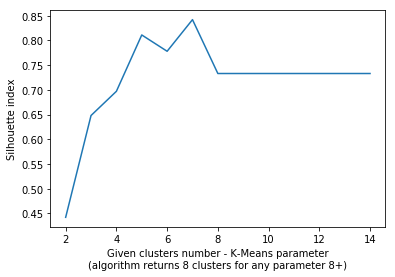

In [12]:
print('Silhouette index in a range of cluster numbers')
plt.plot(sil_range['NC'], sil_range['Silhouette'])
plt.xlabel('Given clusters number - K-Means parameter\n' + \
           '(algorithm returns 8 clusters for any parameter 8+)')
plt.ylabel('Silhouette index')
plt.show()

Cluster inertia (k-means metric) - seems useless?


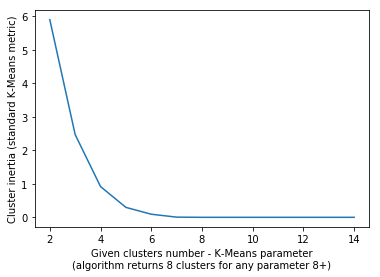

In [13]:
print('Cluster inertia (k-means metric) - seems useless?')
plt.plot(sil_range['NC'], sil_range['Inertia'])
plt.xlabel('Given clusters number - K-Means parameter\n' + \
           '(algorithm returns 8 clusters for any parameter 8+)')
plt.ylabel('Cluster inertia (standard K-Means metric)')
plt.show()

The cluster inertia metric built in k-means clustering library does not provide any useful information on the clustering quality.  
The silhouette metric definitely defines 7 as the optimal number of clusters for the given corpus.

## 1.6 Correlation between dimensions and clusters

In [14]:
n = 7  # Number of clusters, defined by max Silhouette index
silhouette, inertia, cluster_labels, centroids, cluster_sizes, \
    cluster_word_ids, cluster_words = cluster_kmeans(n, df, words)
print(n, 'clusters - sizes:', cluster_sizes)
#?print('\n'.join(str(i)+'. '+str(c) for i,c in enumerate(cluster_words)))
#?print('Silhouette index:', silhouette)
#-print('words:', words)
#-print('cluster_labels:  ', cluster_labels)
#print('cluster_sizes:   ', cluster_sizes)
#-print('cluster_word_ids:', cluster_word_ids)
print('cluster_words:', cluster_words)

7 clusters - sizes: [2, 4, 2, 1, 3, 2, 1]
cluster_words: [['feather', 'scale'], ['eagle', 'herring', 'parrot', 'tuna'], ['has', 'isa'], ['.'], ['bird', 'extremity', 'fish'], ['fin', 'wing'], ['###LEFT-WALL###']]


### 1.6.1 Cluster centroids in vector space

In [15]:
print('Cluster centroid vectors, values rounded')
cdf = pd.DataFrame(centroids)
def zeros(x):
    if abs(x) > 1e-13: return round(x,3)
    else: return 0
def row_index(row): return int(row.name)
def cluster_word_list(row): return cluster_words[int(row.name)]
cls_df = cdf.applymap(zeros)
cls_df['cluster'] = cls_df.apply(row_index, axis=1)
cls_df['cluster_words'] = cls_df.apply(cluster_word_list, axis=1)
cls_df

Cluster centroid vectors, values rounded


,0,1,2,3,cluster,cluster_words
0,0.000,0.607,0.000,-0.794,0,"[feather, scale]"
1,0.000,0.858,0.000,0.514,1,"[eagle, herring, parrot, tuna]"
2,-0.952,0.000,-0.302,0.000,2,"[has, isa]"
3,-0.409,0.000,0.913,0.000,3,[.]
4,0.000,0.373,0.000,-0.928,4,"[bird, extremity, fish]"
5,0.000,0.988,0.000,-0.156,5,"[fin, wing]"
6,-0.646,0.000,-0.763,0.000,6,[###LEFT-WALL###]


Clusters in vector space - two axes 0 and 1


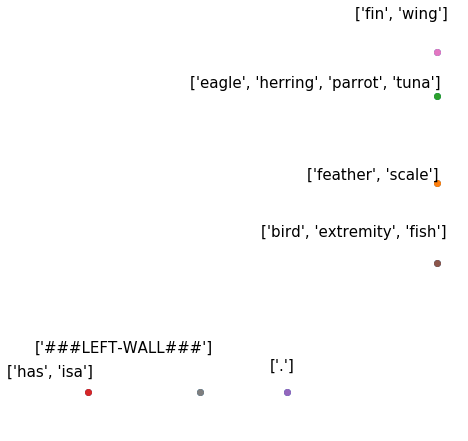

In [16]:
print('Clusters in vector space - two axes 0 and 1''')
font = {'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.scatter(cls_df[0].values, cls_df[1].values)
plt.axis('off')
for i, wlst in enumerate(cls_df['cluster_words']):
    x, y = cls_df[0][i], cls_df[1][i]
    plt.scatter(x, y)
    annot = {'has': (1, 50), 'is': (1, 5)}
    plt.annotate(wlst, xy=(x, y),
                 xytext=annot.get(' '.join(w for w in wlst),(1+i*2, 6*i)), 
                 textcoords='offset points', ha='right', va='bottom', )

### 1.6.2 Check clusters and dimensions correlation  on words

In [17]:
word_clusters = dict()
for i,cluster in enumerate(cluster_words):
    for word in cluster: word_clusters[word] = i
#print('cluster_words:', cluster_words, '\n')
#print('word_clusters:', word_clusters)
def word2cluster(word): return word_clusters[word]
def centroid_axis_value(centroid,axis): return zeros(centroids[centroid][axis])
def centroid_axis_0_value(centroid): return centroid_axis_value(centroid, 0)
def centroid_axis_1_value(centroid): return centroid_axis_value(centroid, 1)
zdf['cluster'] = zdf['word'].apply(word2cluster)
zdf['c1'] = zdf['cluster'].apply(centroid_axis_0_value)
zdf['c2'] = zdf['cluster'].apply(centroid_axis_1_value)
print(readmes('axes_and_clusters_correlation.txt'))
zdf.sort_values('cluster').loc[:,['word',1,2,'cluster','c1','c2']]

Correlation between axes (dimensions) and clusters.
Table columns:
- index - word number in the lexicon,
- 1,2 - word coordinates on axes 1 and 2,
- cluster - cluster number,
- c1,c2 - cluster centroid coordinates on axes 1 and 2


,word,1,2,cluster,c1,c2
5,feather,0.000,0.607,0,0.000,0.607
12,scale,0.000,0.607,0,0.000,0.607
3,eagle,0.000,0.858,1,0.000,0.858
9,herring,0.000,0.858,1,0.000,0.858
11,parrot,0.000,0.858,1,0.000,0.858
13,tuna,0.000,0.858,1,0.000,0.858
8,has,-0.936,0.000,2,-0.952,0.000
10,isa,-0.967,0.000,2,-0.952,0.000
1,.,-0.409,0.000,3,-0.409,0.000
2,bird,0.000,0.373,4,0.000,0.373


**Eureka**!: words belonging to one cluster have the same coordinates with the cluster centroid in the 2D vector space!

Words in 2D vector space: an ugly version of previous plot


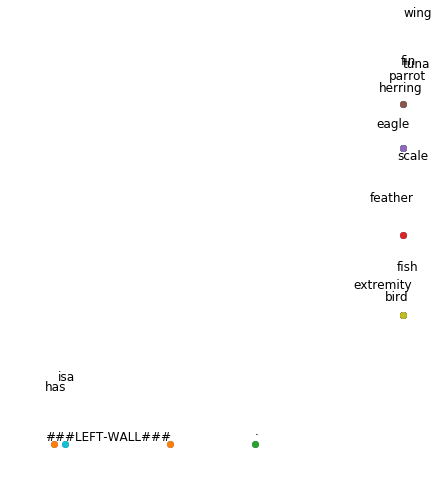

In [18]:
print('Words in 2D vector space: an ugly version of previous plot')
font = {'size'   : 12}
plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.scatter(zdf[1].values, zdf[2].values)
plt.axis('off')
for i, wrd in enumerate(zdf['word']):
    x, y = zdf[1][i], zdf[2][i]
    plt.scatter(x, y)
    annot = {'has': (1, 50), 'is': (1, 5)}
    plt.annotate(wrd, xy=(x, y), xytext=annot.get(wrd,(1+i*2, 6*i)), 
                 textcoords='offset points', ha='right', va='bottom')

## 1.7 From word clusters to words categories

### 1.7.1 Cluster similarity metric: cosine distance between centroids

In [19]:
cls_df  # cluster centroids dataFrame, rounded values

,0,1,2,3,cluster,cluster_words
0,0.000,0.607,0.000,-0.794,0,"[feather, scale]"
1,0.000,0.858,0.000,0.514,1,"[eagle, herring, parrot, tuna]"
2,-0.952,0.000,-0.302,0.000,2,"[has, isa]"
3,-0.409,0.000,0.913,0.000,3,[.]
4,0.000,0.373,0.000,-0.928,4,"[bird, extremity, fish]"
5,0.000,0.988,0.000,-0.156,5,"[fin, wing]"
6,-0.646,0.000,-0.763,0.000,6,[###LEFT-WALL###]


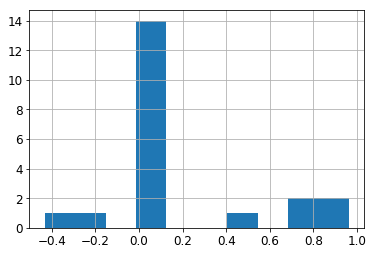

In [20]:
def cluster_similarity(centroids, cluster_words, verbose='none'):
    import numpy as np
    import pandas as pd
    from scipy import spatial
    sim_df = pd.DataFrame(columns=['c1','c2','similarity','c1_words','c2_words'])
    k = 0
    for i in range(len(centroids)):
        c1 = centroids[i]
        for j in range(len(centroids)):
            c2 = centroids[j]
            sim = 1 - spatial.distance.cosine(c1, c2)
            if i < j:
                c1_words = cluster_words[i]
                c2_words = cluster_words[j]
                sim_df.loc[k] = [i, j, sim, c1_words, c2_words]
                k += 1
    sim_df[['c1','c2']] = sim_df[['c1','c2']].astype(int)
    sorted_df = sim_df.sort_values(by=['similarity','c1','c2'], ascending=[False,True,True]) # \
    return sim_df, {'clusters_similarity_file': 'none'}

sim_df, res3 = cluster_similarity(centroids, cluster_words, 'max')
count, division = np.histogram(sim_df['similarity'])
sim_df['similarity'].hist(bins=division)

In [21]:
print('Cluster similarities: absolute values > 1e-10, sorted by similarity descending:')
sim_df.sort_values(by='similarity', ascending=False) \
      .loc[abs(sim_df['similarity']) > 1e-10]

Cluster similarities: absolute values > 1e-10, sorted by similarity descending:


,c1,c2,similarity,c1_words,c2_words
3,0,4,0.963684,"[feather, scale]","[bird, extremity, fish]"
14,2,6,0.846739,"[has, isa]",[###LEFT-WALL###]
9,1,5,0.767100,"[eagle, herring, parrot, tuna]","[fin, wing]"
4,0,5,0.723582,"[feather, scale]","[fin, wing]"
18,4,5,0.512980,"[bird, extremity, fish]","[fin, wing]"
11,2,3,0.113556,"[has, isa]",[.]
0,0,1,0.112252,"[feather, scale]","[eagle, herring, parrot, tuna]"
8,1,4,-0.157181,"[eagle, herring, parrot, tuna]","[bird, extremity, fish]"
17,3,6,-0.432414,[.],[###LEFT-WALL###]


Cosine similarity looks like a sound metric for merging clusters.  
Nouns similarity is clear, **but** what about the verbs similarity to sentence walls?

In [22]:
'''(optional) Full table of cluster similarities, no rounding'''
sim_df #.sort_values(by='similarity', ascending=False)

,c1,c2,similarity,c1_words,c2_words
0,0,1,1.122519e-01,"[feather, scale]","[eagle, herring, parrot, tuna]"
1,0,2,2.819966e-14,"[feather, scale]","[has, isa]"
2,0,3,1.032507e-14,"[feather, scale]",[.]
3,0,4,9.636843e-01,"[feather, scale]","[bird, extremity, fish]"
4,0,5,7.235816e-01,"[feather, scale]","[fin, wing]"
5,0,6,8.992806e-15,"[feather, scale]",[###LEFT-WALL###]
6,1,2,-2.509104e-14,"[eagle, herring, parrot, tuna]","[has, isa]"
7,1,3,-9.992007e-15,"[eagle, herring, parrot, tuna]",[.]
8,1,4,-1.571812e-01,"[eagle, herring, parrot, tuna]","[bird, extremity, fish]"
9,1,5,7.670998e-01,"[eagle, herring, parrot, tuna]","[fin, wing]"


### 1.7.2 Are 2 dimensions enough to check cluster similarity?

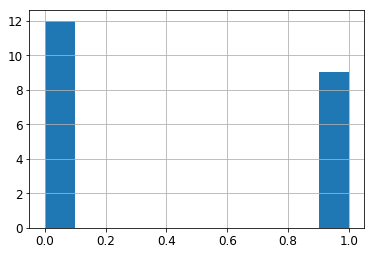

In [23]:
centroids2d = [[c[0], c[1]] for c in centroids]
sim2d, res2d = cluster_similarity(centroids2d, cluster_words, 'max')
count, division = np.histogram(sim2d['similarity'])
sim2d['similarity'].hist(bins=division)

In [24]:
sim2d.sort_values(by='similarity', ascending=False).loc[abs(sim2d['similarity']) > 1e-10]

,c1,c2,similarity,c1_words,c2_words
9,1,5,1.0,"[eagle, herring, parrot, tuna]","[fin, wing]"
8,1,4,1.0,"[eagle, herring, parrot, tuna]","[bird, extremity, fish]"
17,3,6,1.0,[.],[###LEFT-WALL###]
14,2,6,1.0,"[has, isa]",[###LEFT-WALL###]
11,2,3,1.0,"[has, isa]",[.]
0,0,1,1.0,"[feather, scale]","[eagle, herring, parrot, tuna]"
18,4,5,1.0,"[bird, extremity, fish]","[fin, wing]"
3,0,4,1.0,"[feather, scale]","[bird, extremity, fish]"
4,0,5,1.0,"[feather, scale]","[fin, wing]"


**Eureka!**: the two first vector space dimensions provide rough similarity estimates, dividing the corpus in two categories:  
- nouns - merging clusters 1,2,4 with similarities = 1.0  
- verbs, dot and ###LEFT-WALL## - merging clusters 0,3,5 with similarities = 1.0  

### 1.7.3 Are more dimensions better than less for cluster similarity?

In [25]:
# Create 8-dimension vector space:
dim = 8     # Vector space dimensions
df8d,res8d = parses2vec(parses,path,tmpath,dim)
ndf = df8d.copy()
del ndf['word']
# df8d.loc[:,['word',1,2,7,8]]  # uncomment tis line to view vectors

Silhouette index in a range of cluster numbers


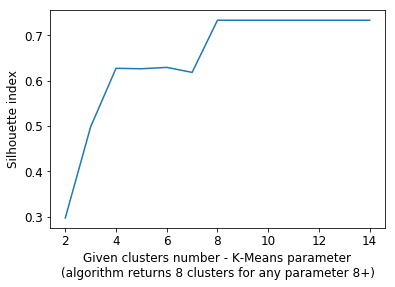

In [26]:
# Find optimal number of clusters by max silhouette index:
s8d_range = pd.DataFrame(columns=['NC','NR','Silhouette','Inertia'])
table = [['N', 'NR', 'Silhouette', 'Clusters']]
for i,j in enumerate(range(2,len(words))):
    silhouette8d, inertia8d, c_labels8d, centroids8d, c_sizes8d, \
        c_word_ids_8d, c_words_8d = cluster_kmeans(j, ndf, words)
    s8d_range.loc[i] = [j, len(c_words_8d), round(silhouette8d,3), inertia8d]
    table.append([j, len(c_words_8d), round(silhouette8d,3), \
        ' | '.join(' '.join(str(word) for word in cluster)
            .replace('###LEFT-WALL###', '#LW#') for cluster in c_words_8d)])
s8d_range['NC'] = s8d_range['NC'].astype(int)
print('Silhouette index in a range of cluster numbers')
plt.plot(s8d_range['NC'], s8d_range['Silhouette'])
plt.xlabel('Given clusters number - K-Means parameter\n' + \
           '(algorithm returns 8 clusters for any parameter 8+)')
plt.ylabel('Silhouette index')
plt.show()

In [27]:
# (optional) Display cluster similarity table
print('K-means clustering in a range of cluster sizes')
display(html_table(table))
print('Table columns:\n', \
    '- N - number of clusters - given K-Means parameter,\n', \
    '- NR - real number of clusters returned by K-Means,\n', \
    '- Silhouette - silhouette coefficient, clustering quality metric,\n', \
    '- Clusters - delimited by "|", cluster words joined with " ",\n', \
    '  "#LW#" substitutes ###LEFT-WALL###\n')

K-means clustering in a range of cluster sizes


N,NR,Silhouette,Clusters
2,2,0.297,#LW# . bird extremity feather fish has isa scale | eagle fin herring parrot tuna wing
3,3,0.498,eagle herring parrot tuna | #LW# . feather fin has isa scale wing | bird extremity fish
4,4,0.627,feather fin scale wing | bird extremity fish | eagle herring parrot tuna | #LW# . has isa
5,5,0.626,bird extremity fish | feather fin scale wing | eagle herring parrot tuna | #LW# has isa | .
6,6,0.629,bird extremity fish | feather fin scale wing | eagle herring parrot tuna | has isa | . | #LW#
7,7,0.618,bird extremity fish | feather fin scale wing | eagle herring parrot tuna | isa | has | . | #LW#
8,8,0.733,isa | feather scale | eagle herring parrot tuna | bird extremity fish | . | has | #LW# | fin wing
9,8,0.733,eagle herring parrot tuna | feather scale | has | bird extremity fish | . | isa | #LW# | fin wing
10,8,0.733,eagle herring parrot tuna | fin wing | bird extremity fish | has | #LW# | . | isa | feather scale
11,8,0.733,feather scale | bird extremity fish | eagle herring parrot tuna | . | has | isa | #LW# | fin wing


Table columns:
 - N - number of clusters - given K-Means parameter,
 - NR - real number of clusters returned by K-Means,
 - Silhouette - silhouette coefficient, clustering quality metric,
 - Clusters - delimited by "|", cluster words joined with " ",
   "#LW#" substitutes ###LEFT-WALL###



In [28]:
# Clusterize the vector space
n8d = 8  # number of clusters, defined by max Silhouette index
print('Cluster the vector space with k-means algorithm,',n8d,'clusters:')
silhouette8d, inertia8d, c_labels_8d, centroids8d, c_sizes_8d, \
    c_word_ids_8d, c_words_8d = cluster_kmeans(n8d, ndf, words)
print('- clusters sizes:', c_sizes_8d)
print('- cluster_words:', c_words_8d)

Cluster the vector space with k-means algorithm, 8 clusters:
- clusters sizes: [1, 2, 3, 4, 1, 1, 1, 2]
- cluster_words: [['.'], ['fin', 'wing'], ['bird', 'extremity', 'fish'], ['eagle', 'herring', 'parrot', 'tuna'], ['has'], ['isa'], ['###LEFT-WALL###'], ['feather', 'scale']]


,c1,c2,similarity,c1_words,c2_words
12,1,7,0.729455,"[fin, wing]","[feather, scale]"
8,1,3,0.487411,"[fin, wing]","[eagle, herring, parrot, tuna]"
22,4,5,0.212294,[has],[isa]
17,2,7,0.163153,"[bird, extremity, fish]","[feather, scale]"
23,4,6,0.094945,[has],[###LEFT-WALL###]
7,1,2,0.085368,"[fin, wing]","[bird, extremity, fish]"
3,0,4,0.038765,[.],[has]
4,0,5,0.038038,[.],[isa]


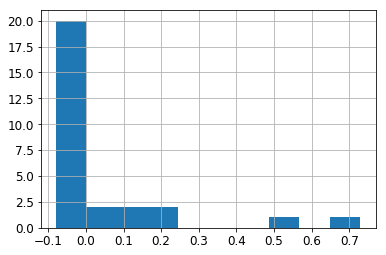

In [29]:
# Find similarities between cluster centroids (1 - cosine distance)
sim8d, res8d = cluster_similarity(centroids8d, c_words_8d, 'max')
count, division = np.histogram(sim8d['similarity'])
sim8d['similarity'].hist(bins=division)
sim8d.sort_values(by='similarity', ascending=False) \
     .loc[(sim8d['similarity']) > 1e-10]

**Good news:**  
The verbs form a clear category with a sund similarity value, separate from the dot and ###LEFT-WALL##.  
The 3 of 4 noun clusters form a clear category.  
**Less good:**:  
The 4th noun cluster [bird, extremity,fish] stays a bit separate, with similarity ~0.16 to the nearest noun cluster.

## 1.8 Aigents aggregative clustering algorithm  
[Aggregative Clustering for Language Learning.gdoc](https://docs.google.com/document/d/1-zyyjqfEbwOq-lqQ94ifSjmuwe0x8RaF0TVjhpMpM0E/edit#heading=h.eb4i3tzgan4x)

In [30]:
'''Hyper-parameters:'''
X = 0.25    # Minimum threshold on similarity between clusters, 
              # clusters similar to less extent are not aggregated
Y = 0.75    # Maximum threshold on similarity between clusters, 
              # clusters similar to greater extent are merged
Z = 100     # Optional parameter for maximum clusters allowed

### 1.8.1 Learning word categories from 7 clusters in 4D vector space

The Aigents algorithm suggests merging clusters with similarities grater than **Y** into one cluster, and aggregating clusters with similarities between **X** and **Y** into one category.

First let's check the idea on 7 clusters of 4D vectors (the first of the above samples):

In [31]:
print('Cluster similarities: 7 clusters, 4D vectors, values >1e-10')
sim_df.sort_values(by='similarity', ascending=False) \
      .loc[abs(sim_df['similarity']) > 1e-10]

Cluster similarities: 7 clusters, 4D vectors, values >1e-10


,c1,c2,similarity,c1_words,c2_words
3,0,4,0.963684,"[feather, scale]","[bird, extremity, fish]"
14,2,6,0.846739,"[has, isa]",[###LEFT-WALL###]
9,1,5,0.767100,"[eagle, herring, parrot, tuna]","[fin, wing]"
4,0,5,0.723582,"[feather, scale]","[fin, wing]"
18,4,5,0.512980,"[bird, extremity, fish]","[fin, wing]"
11,2,3,0.113556,"[has, isa]",[.]
0,0,1,0.112252,"[feather, scale]","[eagle, herring, parrot, tuna]"
8,1,4,-0.157181,"[eagle, herring, parrot, tuna]","[bird, extremity, fish]"
17,3,6,-0.432414,[.],[###LEFT-WALL###]


**Success!** The noun clusters obviously tend to aggregate in a single category.  
**But:**  
 • verbs tend to aggregate with ###LEFT-WALL### with a sound similarity value (0.85!).  
 • 3 of the 4 noun clusters similarity metrics are too high - they tend to merge into a single cluster...  
Can **8D** vectors (the last of the above samples) help?

### 1.8.2 Learning word categories from 8 clusters in 8D vector space

In [32]:
print('8D word vector space:')
df8z = ndf.applymap(zeros)
df8z['word'] = df8d['word']
df8z.loc[:,['word',1,2,3,4,5,6,7,8]].sort_values(by=[1,2],ascending=[True,True])

8D word vector space:


,word,1,2,3,4,5,6,7,8
8,has,-0.729,0.000,-0.273,0.000,-0.016,0.000,0.628,0.000
10,isa,-0.688,0.000,-0.180,0.000,-0.436,0.000,-0.551,0.000
1,.,-0.402,0.000,0.896,0.000,0.188,0.000,-0.010,0.000
0,###LEFT-WALL###,-0.258,0.000,-0.305,0.000,0.880,0.000,-0.257,0.000
2,bird,0.000,0.312,0.000,-0.776,0.000,0.548,0.000,0.006
4,extremity,0.000,0.312,0.000,-0.776,0.000,0.548,0.000,0.006
7,fish,0.000,0.312,0.000,-0.776,0.000,0.548,0.000,0.006
5,feather,0.000,0.418,0.000,-0.547,0.000,-0.714,0.000,-0.128
12,scale,0.000,0.418,0.000,-0.547,0.000,-0.714,0.000,-0.128
6,fin,0.000,0.816,0.000,-0.128,0.000,-0.494,0.000,0.271


In [33]:
print('Cluster centroids cosine similarity in 8D vector space:')
sim8d.sort_values(by='similarity', ascending=False).loc[(sim8d['similarity']) > 1e-10]

Cluster centroids cosine similarity in 8D vector space:


,c1,c2,similarity,c1_words,c2_words
12,1,7,0.729455,"[fin, wing]","[feather, scale]"
8,1,3,0.487411,"[fin, wing]","[eagle, herring, parrot, tuna]"
22,4,5,0.212294,[has],[isa]
17,2,7,0.163153,"[bird, extremity, fish]","[feather, scale]"
23,4,6,0.094945,[has],[###LEFT-WALL###]
7,1,2,0.085368,"[fin, wing]","[bird, extremity, fish]"
3,0,4,0.038765,[.],[has]
4,0,5,0.038038,[.],[isa]


**Good news:**  
• We can separate verbs from the dot and ###LEFT-WALL##.  
• Nouns don't tend to merge in a single cluster with a default **Y**=0.75 treshold.  
**A minor problem:**  
We need **X**=0.1-0.16 treshold setting to form a single category for the 4 noun clusters.

### Can we improve aggregation by using a limited number of axes in 8D clusters?  
TL;DR: No. The following 5 tests show category prediction quality degradation using 6 to 2 axes of the 4 dimension.

Inter-cluster similarity for 8D limited vector space


,c1,c2,similarity,c1_words,c2_words
12,1,7,0.729455,"[fin, wing]","[feather, scale]"
8,1,3,0.487411,"[fin, wing]","[eagle, herring, parrot, tuna]"
22,4,5,0.212294,[has],[isa]
17,2,7,0.163153,"[bird, extremity, fish]","[feather, scale]"
23,4,6,0.094945,[has],[###LEFT-WALL###]
7,1,2,0.085368,"[fin, wing]","[bird, extremity, fish]"
3,0,4,0.038765,[.],[has]
4,0,5,0.038038,[.],[isa]


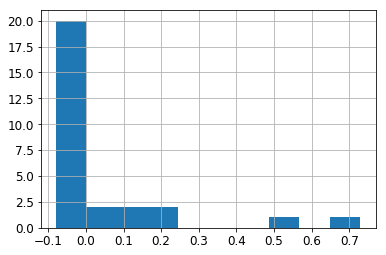

In [34]:
# Use 6 axes of 8:
def limit_axes(n_axis, centroids8d):
    print('Inter-cluster similarity for', str(n_axis)+'D limited vector space')
    centroids_x = [c[0:n_axis] for c in centroids8d]
    sim_x, res_x = cluster_similarity(centroids_x, c_words_8d)
    count, division = np.histogram(sim_x['similarity'])
    sim_x['similarity'].hist(bins=division)
    return sim_x
sim_x = limit_axes(8, centroids8d)
sim_x.sort_values(by='similarity', ascending=False).loc[(sim_x['similarity']) > 1e-10]

Looks better: verbs form a clear single cluster (similarity 0.86 > **Y**=0.75), but the ##LEFT-WALL## is too close to the verbs... Closer than the **X** treshold value necessary to form a single noun category...

Inter-cluster similarity for 4D limited vector space


,c1,c2,similarity,c1_words,c2_words
22,4,5,0.994796,[has],[isa]
17,2,7,0.963684,"[bird, extremity, fish]","[feather, scale]"
23,4,6,0.872774,[has],[###LEFT-WALL###]
25,5,6,0.818499,[isa],[###LEFT-WALL###]
8,1,3,0.767100,"[fin, wing]","[eagle, herring, parrot, tuna]"
12,1,7,0.723582,"[fin, wing]","[feather, scale]"
7,1,2,0.512980,"[fin, wing]","[bird, extremity, fish]"
4,0,5,0.164088,[.],[isa]
21,3,7,0.112252,"[eagle, herring, parrot, tuna]","[feather, scale]"
3,0,4,0.062729,[.],[has]


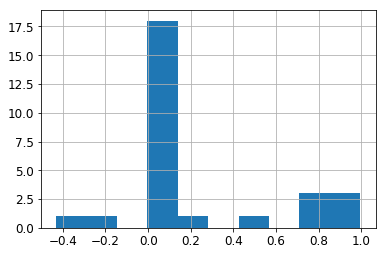

In [35]:
# Use 5 axes of 8:
sim_x = limit_axes(4, centroids8d)
sim_x.sort_values(by='similarity', ascending=False).loc[abs(sim_x['similarity']) > 1e-10]

Inter-cluster similarity for 4D limited vector space


,c1,c2,similarity,c1_words,c2_words
22,4,5,0.994796,[has],[isa]
17,2,7,0.963684,"[bird, extremity, fish]","[feather, scale]"
23,4,6,0.872774,[has],[###LEFT-WALL###]
25,5,6,0.818499,[isa],[###LEFT-WALL###]
8,1,3,0.767100,"[fin, wing]","[eagle, herring, parrot, tuna]"
12,1,7,0.723582,"[fin, wing]","[feather, scale]"
7,1,2,0.512980,"[fin, wing]","[bird, extremity, fish]"
4,0,5,0.164088,[.],[isa]
21,3,7,0.112252,"[eagle, herring, parrot, tuna]","[feather, scale]"
3,0,4,0.062729,[.],[has]


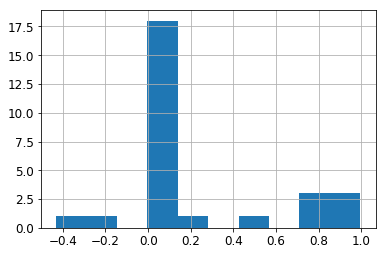

In [36]:
# Use 4 axes of 8:
sim_x = limit_axes(4, centroids8d)
sim_x.sort_values(by='similarity', ascending=False).loc[abs(sim_x['similarity']) > 1e-10]

Inter-cluster similarity for 3D limited vector space


,c1,c2,similarity,c1_words,c2_words
8,1,3,1.000000,"[fin, wing]","[eagle, herring, parrot, tuna]"
17,2,7,1.000000,"[bird, extremity, fish]","[feather, scale]"
13,2,3,1.000000,"[bird, extremity, fish]","[eagle, herring, parrot, tuna]"
21,3,7,1.000000,"[eagle, herring, parrot, tuna]","[feather, scale]"
7,1,2,1.000000,"[fin, wing]","[bird, extremity, fish]"
12,1,7,1.000000,"[fin, wing]","[feather, scale]"
22,4,5,0.994796,[has],[isa]
23,4,6,0.872774,[has],[###LEFT-WALL###]
25,5,6,0.818499,[isa],[###LEFT-WALL###]
4,0,5,0.164088,[.],[isa]


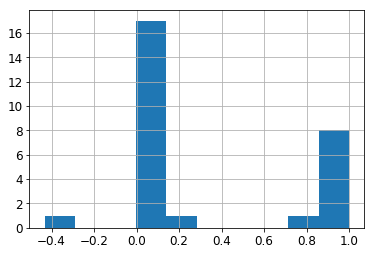

In [37]:
sim_x = limit_axes(3, centroids8d)
sim_x.sort_values(by='similarity', ascending=False).loc[abs(sim_x['similarity']) > 1e-10]

Inter-cluster similarity for 2D limited vector space


,c1,c2,similarity,c1_words,c2_words
17,2,7,1.0,"[bird, extremity, fish]","[feather, scale]"
7,1,2,1.0,"[fin, wing]","[bird, extremity, fish]"
25,5,6,1.0,[isa],[###LEFT-WALL###]
3,0,4,1.0,[.],[has]
4,0,5,1.0,[.],[isa]
5,0,6,1.0,[.],[###LEFT-WALL###]
8,1,3,1.0,"[fin, wing]","[eagle, herring, parrot, tuna]"
23,4,6,1.0,[has],[###LEFT-WALL###]
21,3,7,1.0,"[eagle, herring, parrot, tuna]","[feather, scale]"
12,1,7,1.0,"[fin, wing]","[feather, scale]"


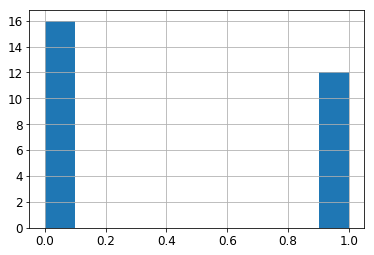

In [38]:
sim_x = limit_axes(2, centroids8d)
sim_x.sort_values(by='similarity', ascending=False).loc[abs(sim_x['similarity']) > 1e-10]

The 2 dimensions of the 8D vector space performs the same as the 4D in terms of binary clustering.

## Resume:

This (1st) part of research shows the possibility of statistical machine learning use for unsupervised natural language learning. Simple algorithms on small data demonstrate the ability to learn word grammar categories from a simplistec text corpus.  

The next steps include testing agglomerative clustering algorithms & clustering quality metrics, learning links between word clusters as a way to infer natural language grammar, and further development with expanding corpora...